# Sentiment Analysis of Product Based Reviews Using Machine Learning 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>



The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


## Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
# import libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import GridSearchCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.linear_model import LogisticRegression

from tqdm import tqdm
import os

from prettytable import PrettyTable

## Reading Data

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# we can change the number to any other number based on our computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

##  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delete the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
# Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
# Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
# Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
# Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

# How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'html.parser')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
# remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
# remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above statements
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:07<00:00, 1946.66it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [24]:
X = preprocessed_reviews # store preprocessed_reviews in variable X
y = final["Score"]       # store values of feature "Score"
print("Size of class label :",len(y))
print("Class Label         :")
print(y)
print()
print("Number of data points belonging to each class label: ")
print(final["Score"].value_counts())
print()
print("Size of preprocessed reviews:",len(X))
print("Preprocessed review:")
X[1500]

Size of class label : 364171
Class Label         :
138706    1
138688    1
138689    1
138690    1
138691    1
         ..
178145    1
173675    1
204727    1
5259      1
302474    1
Name: Score, Length: 364171, dtype: int64

Number of data points belonging to each class label: 
1    307061
0     57110
Name: Score, dtype: int64

Size of preprocessed reviews: 364171
Preprocessed review:


'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

##  Splitting data into Train and cross validation(or test): Stratified Sampling

In [25]:
# Split the dataset in X_train, X_test, y_train, y_test using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y)
print("Size of X_train :", len(X_train))
print("Size of X_test  :", len(X_test))
print("Shape of y_train :", y_train.shape)
print("Shape of y_test  :", y_test.shape)

Size of X_train : 243994
Size of X_test  : 120177
Shape of y_train : (243994,)
Shape of y_test  : (120177,)


## Featurization

## BAG OF WORDS

In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaacccccccckkkkkk']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (243994, 95195)
the number of unique words  95195


In [27]:
import pickle
filename_transform = 'transformBoW.pkl' 
pickle.dump(count_vect, open(filename_transform, 'wb'))

In [28]:
# apply logistic regression on BoW
logisticregression = LogisticRegression(class_weight = 'balanced')
parameters = {"C": [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]}
clf = GridSearchCV(logisticregression,parameters,cv=3,scoring="roc_auc",return_train_score=True,n_jobs=-1)
clf.fit(X_train_bow,y_train)
bow_result = pd.DataFrame.from_dict(clf.cv_results_)
print("Shape of Results Dataset:",bow_result.shape)
bow_result.head()

Shape of Results Dataset: (6, 17)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.958244,0.163557,0.139671,0.010354,0.001,{'C': 0.001},0.925865,0.927057,0.927602,0.926841,0.000725,6,0.932040,0.931559,0.931512,0.931704,0.000239
1,14.694547,0.836985,0.133160,0.013234,0.01,{'C': 0.01},0.944895,0.946902,0.947024,0.946274,0.000976,1,0.958360,0.958019,0.957931,0.958103,0.000185
2,18.647993,0.379384,0.128670,0.009164,1,{'C': 1},0.941287,0.944031,0.942985,0.942768,0.001131,2,0.984466,0.984421,0.984932,0.984606,0.000231
3,19.238211,0.081547,0.135476,0.007004,100,{'C': 100},0.930875,0.936353,0.934936,0.934055,0.002321,3,0.986066,0.986375,0.985841,0.986094,0.000219
4,20.374227,0.158085,0.141307,0.012035,1000,{'C': 1000},0.930359,0.937532,0.932137,0.933343,0.003050,5,0.986550,0.985891,0.986755,0.986399,0.000368


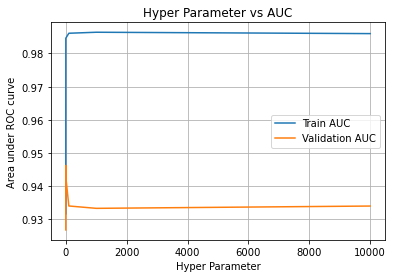

Best Parameters:
LogisticRegression(C=0.01, class_weight='balanced')


In [29]:
# finding the best hyper parameter for BoW
train_auc = bow_result["mean_train_score"]
train_auc_std = bow_result["std_train_score"]
cv_auc = bow_result["mean_test_score"]
cv_auc_std = bow_result["std_test_score"]
a = bow_result["param_C"]
#plt.figure(figsize=(10,5))
plt.plot(a,train_auc,label="Train AUC")
plt.plot(a,cv_auc,label="Validation AUC")
plt.title("Hyper Parameter vs AUC")
plt.xlabel("Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.legend()
plt.grid()
plt.show()

print("Best Parameters:")
print(clf.best_estimator_)

In [30]:
# best hyper paramter
# C = 0.01

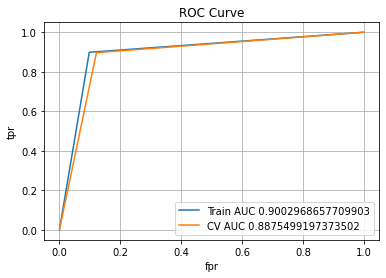

In [30]:
# train model with best parameters
# find the AUC on test data and plot the ROC curve on both train and test
logisticregression = LogisticRegression(C=0.01,class_weight='balanced')
logisticregression.fit(X_train_bow, y_train)
ytrain_pred = logisticregression.predict(X_train_bow)
ytest_pred = logisticregression.predict(X_test_bow)
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train,ytrain_pred)
te_fpr, te_tpr, te_thresholds = roc_curve(y_test,ytest_pred)
plt.plot(tr_fpr,tr_tpr,label="Train AUC "+str(auc(tr_fpr,tr_tpr)))
plt.plot(te_fpr,te_tpr,label="CV AUC "+str(auc(te_fpr,te_tpr)))
plt.title("ROC Curve")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.grid()
plt.show()

In [31]:
filename_model = 'bow.pkl'
pickle.dump(logisticregression, open(filename_model, 'wb'))

In [32]:
pred = logisticregression.predict_proba(X_test_bow[5000])
print(pred)

[[0.33193036 0.66806964]]


In [33]:
print(preprocessed_reviews[59])

tried several different kinds training treats pet stores either made english bulldog puppy sick lose interest liver working great absolutely loves keep attention


In [34]:
# compute the best threhold
def find_best_threshold(fpr,tpr,threshold):
    t = threshold[np.argmax(tpr*(1-fpr))]
    return t

def compute_with_best_threhold(proba,threhold):
    predictions = []
    for i in proba:
        if i>=threhold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
best_t = find_best_threshold(te_fpr,te_tpr,te_thresholds)
print("Best threhold value is : ",best_t)

Best threhold value is :  1


Text(33.0, 0.5, 'Predicted')

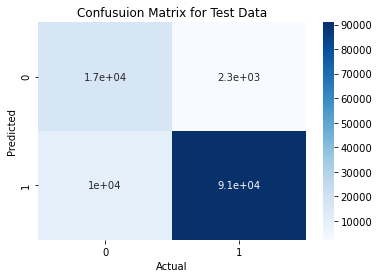

In [35]:
# plot confusuon matrix for test dataset
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test,compute_with_best_threhold(ytest_pred,best_t)),annot=True,ax=ax,cmap="Blues")
ax.set_title("Confusuion Matrix for Test Data")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")

## Bi-Grams and n-Grams.

In [36]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# CountVectorizer documentation: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vect.fit(X_train)
X_train_ngram = count_vect.transform(X_train)
X_test_ngram = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_ngram))
print("the shape of out text BOW vectorizer ",X_train_ngram.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_ngram.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (243994, 5000)
the number of unique words including both unigrams and bigrams  5000


In [37]:
filename_transform = 'transformBiGramNgram.pkl'
pickle.dump(count_vect, open(filename_transform, 'wb'))

In [38]:
# apply logistic regression on n-Grams
logisticregression = LogisticRegression(class_weight = 'balanced')
parameters = {"C": [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]}
clf = GridSearchCV(logisticregression,parameters,cv=3,scoring="roc_auc",return_train_score=True,n_jobs=-1)
clf.fit(X_train_ngram,y_train)
ngram_result = pd.DataFrame.from_dict(clf.cv_results_)
print("Shape of Results Dataset:",ngram_result.shape)
ngram_result.head()

Shape of Results Dataset: (6, 17)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.824305,0.034036,0.134470,0.022171,0.001,{'C': 0.001},0.932498,0.933979,0.934229,0.933569,0.000764,6,0.938193,0.937492,0.937608,0.937764,0.000307
1,7.620529,0.181305,0.127724,0.012675,0.01,{'C': 0.01},0.952353,0.954495,0.954341,0.953730,0.000976,1,0.963102,0.962433,0.962608,0.962714,0.000283
2,9.842764,0.184061,0.127994,0.008000,1,{'C': 1},0.952485,0.954299,0.954326,0.953703,0.000861,2,0.975066,0.974572,0.974927,0.974855,0.000208
3,9.938176,0.070800,0.120867,0.005821,100,{'C': 100},0.951019,0.952448,0.953094,0.952187,0.000867,4,0.975212,0.974690,0.974996,0.974966,0.000214
4,9.866833,0.104953,0.121367,0.009538,1000,{'C': 1000},0.951130,0.952334,0.952929,0.952131,0.000749,5,0.975195,0.974641,0.974975,0.974937,0.000228


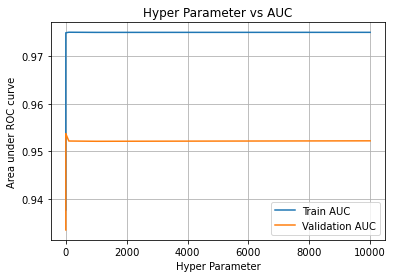

Best Parameters:
LogisticRegression(C=0.01, class_weight='balanced')


In [39]:
# finding the best hyper parameter for n-gram 
train_auc = ngram_result["mean_train_score"]
train_auc_std = ngram_result["std_train_score"]
cv_auc = ngram_result["mean_test_score"]
cv_auc_std = ngram_result["std_test_score"]
a = ngram_result["param_C"]
#plt.figure(figsize=(10,5))
plt.plot(a,train_auc,label="Train AUC")
plt.plot(a,cv_auc,label="Validation AUC")
plt.title("Hyper Parameter vs AUC")
plt.xlabel("Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.legend()
plt.grid()
plt.show()

print("Best Parameters:")
print(clf.best_estimator_)

In [40]:
# best hyper paramter
# C = 0.01

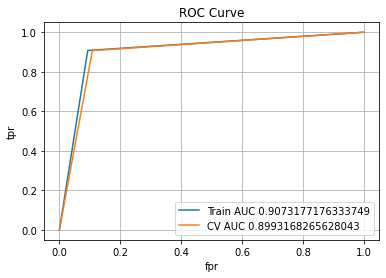

In [41]:
# train model with best parameters
# find the AUC on test data and plot the ROC curve on both train and test
logisticregression = LogisticRegression(C=0.01,class_weight='balanced')
logisticregression.fit(X_train_ngram, y_train)
ytrain_pred = logisticregression.predict(X_train_ngram)
ytest_pred = logisticregression.predict(X_test_ngram)
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train,ytrain_pred)
te_fpr, te_tpr, te_thresholds = roc_curve(y_test,ytest_pred)
plt.plot(tr_fpr,tr_tpr,label="Train AUC "+str(auc(tr_fpr,tr_tpr)))
plt.plot(te_fpr,te_tpr,label="CV AUC "+str(auc(te_fpr,te_tpr)))
plt.title("ROC Curve")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.grid()
plt.show()

In [42]:
filename_model = 'BandNgram.pkl'
pickle.dump(logisticregression, open(filename_model, 'wb'))

In [43]:
# compute the best threhold
def find_best_threshold(fpr,tpr,threshold):
    t = threshold[np.argmax(tpr*(1-fpr))]
    return t

def compute_with_best_threhold(proba,threhold):
    predictions = []
    for i in proba:
        if i>=threhold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
best_t = find_best_threshold(te_fpr,te_tpr,te_thresholds)
print("Best threhold value is : ",best_t)

Best threhold value is :  1


Text(33.0, 0.5, 'Predicted')

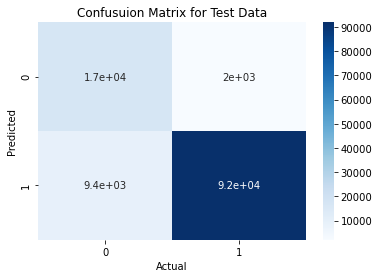

In [44]:
# plot confusuon matrix for test dataset
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test,compute_with_best_threhold(ytest_pred,best_t)),annot=True,ax=ax,cmap="Blues")
ax.set_title("Confusuion Matrix for Test Data")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")

## TF-IDF

In [45]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaaa', 'aaah', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (243994, 140333)
the number of unique words including both unigrams and bigrams  140333


In [46]:
filename_transform = 'TFidfTransform.pkl'
pickle.dump(tf_idf_vect, open(filename_transform, 'wb'))

In [47]:
# apply logistic regression on TF-IDF
logisticregression = LogisticRegression(class_weight = 'balanced')
parameters = {"C": [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]}
clf = GridSearchCV(logisticregression,parameters,cv=3,scoring="roc_auc",return_train_score=True,n_jobs=-1)
clf.fit(X_train_tfidf,y_train)
tfidf_result = pd.DataFrame.from_dict(clf.cv_results_)
print("Shape of Results Dataset:",tfidf_result.shape)
tfidf_result.head()

Shape of Results Dataset: (6, 17)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.437476,0.204955,0.147634,0.010860,0.001,{'C': 0.001},0.911015,0.908918,0.914248,0.911394,0.002193,6,0.914837,0.914930,0.914733,0.914833,0.000081
1,8.808802,0.299220,0.136689,0.016742,0.01,{'C': 0.01},0.928628,0.927332,0.931309,0.929089,0.001656,5,0.933895,0.933597,0.933328,0.933607,0.000232
2,38.087211,0.136797,0.150821,0.008870,1,{'C': 1},0.969295,0.970597,0.970578,0.970157,0.000609,1,0.989203,0.989068,0.989159,0.989143,0.000056
3,37.872150,1.148522,0.164868,0.014622,100,{'C': 100},0.967673,0.968835,0.969043,0.968517,0.000603,2,0.999930,0.999906,0.999451,0.999762,0.000221
4,37.845112,1.198087,0.154455,0.021579,1000,{'C': 1000},0.964922,0.966329,0.965599,0.965617,0.000574,3,0.999972,0.999945,0.999924,0.999947,0.000020


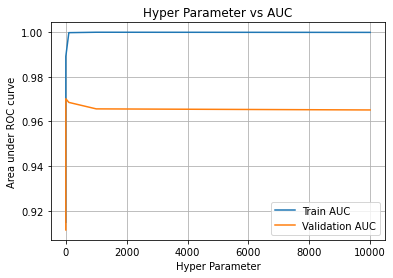

Best Parameters:
LogisticRegression(C=1, class_weight='balanced')


In [48]:
# finding the best hyper parameter for TF-IDF
train_auc = tfidf_result["mean_train_score"]
train_auc_std = tfidf_result["std_train_score"]
cv_auc = tfidf_result["mean_test_score"]
cv_auc_std = tfidf_result["std_test_score"]
a = tfidf_result["param_C"]
#plt.figure(figsize=(10,5))
plt.plot(a,train_auc,label="Train AUC")
plt.plot(a,cv_auc,label="Validation AUC")
plt.title("Hyper Parameter vs AUC")
plt.xlabel("Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.legend()
plt.grid()
plt.show()

print("Best Parameters:")
print(clf.best_estimator_)

In [49]:
# best hyper paramter
# C = 1

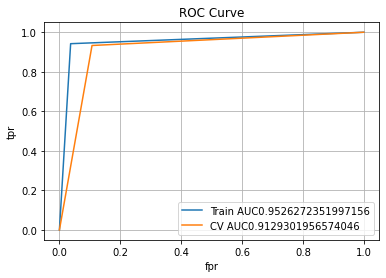

In [50]:
# train model with best parameters
# find the AUC on test data and plot the ROC curve on both train and test
logisticregression = LogisticRegression(C=1,class_weight='balanced')
logisticregression.fit(X_train_tfidf, y_train)
ytrain_pred = logisticregression.predict(X_train_tfidf)
ytest_pred = logisticregression.predict(X_test_tfidf)
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train,ytrain_pred)
te_fpr, te_tpr, te_thresholds = roc_curve(y_test,ytest_pred)
plt.plot(tr_fpr,tr_tpr,label="Train AUC"+str(auc(tr_fpr,tr_tpr)))
plt.plot(te_fpr,te_tpr,label="CV AUC"+str(auc(te_fpr,te_tpr)))
plt.title("ROC Curve")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.grid()
plt.show()

In [51]:
filename_model = 'TFiDF.pkl'
pickle.dump(logisticregression, open(filename_model, 'wb'))

In [52]:
# compute the best threhold
def find_best_threshold(fpr,tpr,threshold):
    t = threshold[np.argmax(tpr*(1-fpr))]
    return t

def compute_with_best_threhold(proba,threhold):
    predictions = []
    for i in proba:
        if i>=threhold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
best_t = find_best_threshold(te_fpr,te_tpr,te_thresholds)
print("Best threhold value is : ",best_t)

Best threhold value is :  1


Text(33.0, 0.5, 'Predicted')

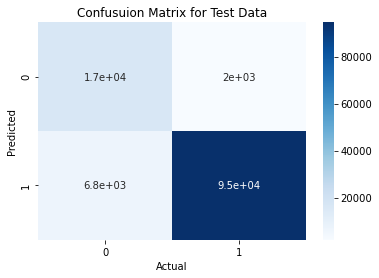

In [53]:
# plot confusuon matrix for test dataset
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test,compute_with_best_threhold(ytest_pred,best_t)),annot=True,ax=ax,cmap="Blues")
ax.set_title("Confusuion Matrix for Test Data")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")

## Word2Vec

In [54]:
# Train our own Word2Vec model using our own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [55]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once we load this into the memory 
# it occupies ~9Gb, 
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8836475014686584), ('good', 0.8671817183494568), ('fantastic', 0.8649238348007202), ('awesome', 0.857620358467102), ('excellent', 0.8342537879943848), ('wonderful', 0.7997217774391174), ('perfect', 0.7723845839500427), ('nice', 0.7344862818717957), ('decent', 0.7193624973297119), ('fabulous', 0.7095255255699158)]
[('nastiest', 0.8156264424324036), ('best', 0.7707960605621338), ('greatest', 0.7563451528549194), ('disgusting', 0.7469466328620911), ('terrible', 0.7291384339332581), ('awful', 0.7096807956695557), ('horrible', 0.7051016688346863), ('tastiest', 0.6978250741958618), ('horrid', 0.6865740418434143), ('smoothest', 0.6591708660125732)]


In [56]:
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  28266
sample words  ['not', 'like', 'good', 'great', 'one', 'taste', 'product', 'would', 'flavor', 'coffee', 'tea', 'love', 'no', 'get', 'food', 'really', 'amazon', 'use', 'much', 'also', 'time', 'little', 'best', 'find', 'buy', 'price', 'make', 'even', 'well', 'tried', 'try', 'better', 'chocolate', 'eat', 'sugar', 'first', 'water', 'used', 'could', 'found', 'made', 'sweet', 'free', 'bag', 'drink', 'bought', 'cup', 'dog', 'box', 'way']


## Converting text into vectors using wAvg W2V, TFIDF-W2V

## Avg Word2Vec

In [57]:
# average Word2Vec
# Train Word2Vec model using text corpus
i=0
train_list_of_sentance=[]
for sentance in X_train:
    train_list_of_sentance.append(sentance.split())
# compute average word2vec for each review.
X_train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(train_list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)
    
i=0
test_list_of_sentance=[]
for sentance in X_test:
    test_list_of_sentance.append(sentance.split())
# compute average word2vec for each review.
X_test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(test_list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)
    
print(len(X_train_avgw2v))
print(len(X_train_avgw2v[0]))

100%|██████████| 120177/120177 [14:40<00:00, 136.46it/s]

243994
50


In [58]:
# apply logistic regression on avg Word2Vec
logisticregression = LogisticRegression(class_weight = 'balanced')
parameters = {"C": [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]}
clf = GridSearchCV(logisticregression,parameters,cv=3,scoring="roc_auc",return_train_score=True,n_jobs=-1)
clf.fit(X_train_avgw2v,y_train)
avgw2v_result = pd.DataFrame.from_dict(clf.cv_results_)
print("Shape of Results Dataset:",avgw2v_result.shape)
avgw2v_result.head()

Shape of Results Dataset: (6, 17)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.008973,0.061104,0.195758,0.021338,0.001,{'C': 0.001},0.919658,0.920208,0.922977,0.920947,0.001452,6,0.921860,0.921421,0.920162,0.921148,0.000720
1,2.626985,0.155321,0.192196,0.013500,0.01,{'C': 0.01},0.920507,0.921468,0.923923,0.921966,0.001439,5,0.922939,0.922447,0.921239,0.922208,0.000714
2,3.050855,0.229049,0.196178,0.010183,1,{'C': 1},0.920723,0.921929,0.924199,0.922284,0.001441,1,0.923301,0.922740,0.921588,0.922543,0.000713
3,3.158093,0.158235,0.199637,0.032949,100,{'C': 100},0.920716,0.921936,0.924194,0.922282,0.001441,2,0.923301,0.922739,0.921587,0.922542,0.000713
4,3.142141,0.104360,0.176945,0.012561,1000,{'C': 1000},0.920716,0.921936,0.924194,0.922282,0.001441,3,0.923301,0.922739,0.921587,0.922542,0.000713


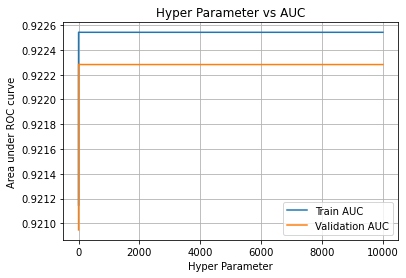

Best Parameters:
LogisticRegression(C=1, class_weight='balanced')


In [59]:
# finding the best hyper parameter for avg Word2Vec
train_auc = avgw2v_result["mean_train_score"]
train_auc_std = avgw2v_result["std_train_score"]
cv_auc = avgw2v_result["mean_test_score"]
cv_auc_std = avgw2v_result["std_test_score"]
a = avgw2v_result["param_C"]
#plt.figure(figsize=(10,5))
plt.plot(a,train_auc,label="Train AUC")
plt.plot(a,cv_auc,label="Validation AUC")
plt.title("Hyper Parameter vs AUC")
plt.xlabel("Hyper Parameter")
plt.ylabel("Area under ROC curve")
plt.legend()
plt.grid()
plt.show()

print("Best Parameters:")
print(clf.best_estimator_)

In [60]:
# best hyper paramter
# C = 1

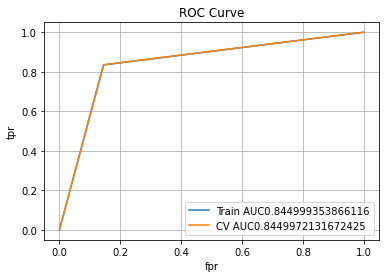

In [61]:
# train model with best parameters
# find the AUC on test data and plot the ROC curve on both train and test
logisticregression = LogisticRegression(C=1,class_weight='balanced')
logisticregression.fit(X_train_avgw2v, y_train)
ytrain_pred = logisticregression.predict(X_train_avgw2v)
ytest_pred = logisticregression.predict(X_test_avgw2v)
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train,ytrain_pred)
te_fpr, te_tpr, te_thresholds = roc_curve(y_test,ytest_pred)
plt.plot(tr_fpr,tr_tpr,label="Train AUC"+str(auc(tr_fpr,tr_tpr)))
plt.plot(te_fpr,te_tpr,label="CV AUC"+str(auc(te_fpr,te_tpr)))
plt.title("ROC Curve")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.grid()
plt.show()

In [62]:
# compute the best threhold
def find_best_threshold(fpr,tpr,threshold):
    t = threshold[np.argmax(tpr*(1-fpr))]
    return t

def compute_with_best_threhold(proba,threhold):
    predictions = []
    for i in proba:
        if i>=threhold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
best_t = find_best_threshold(te_fpr,te_tpr,te_thresholds)
print("Best threhold value is : ",best_t)

Best threhold value is :  1


Text(33.0, 0.5, 'Predicted')

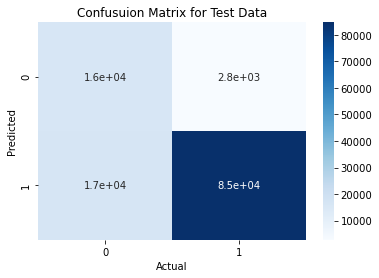

In [63]:
# plot confusuon matrix for test dataset
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test,compute_with_best_threhold(ytest_pred,best_t)),annot=True,ax=ax,cmap="Blues")
ax.set_title("Confusuion Matrix for Test Data")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")

In [64]:
# Reference: https://github.com/shubham9471/Decision-Tree-/blob/main/Decision_Tree_1.ipynb
x=PrettyTable()
x.field_names=["Vectorizer","Model","C","AUC"]
x.add_row(["Avg-Word2Vec","Logistic Regression","1","0.8449"])
x.add_row(["Bag of Words","Logistic Regression","0.01","0.8875"])
x.add_row(["Bi-Grams and n-Grams","Logistic Regression","0.01","0.8993"])
x.add_row(["TF-IDF","Logistic Regression","1","0.9129"])
print(x)

+----------------------+---------------------+------+--------+
|      Vectorizer      |        Model        |  C   |  AUC   |
+----------------------+---------------------+------+--------+
|     Avg-Word2Vec     | Logistic Regression |  1   | 0.8449 |
|     Bag of Words     | Logistic Regression | 0.01 | 0.8875 |
| Bi-Grams and n-Grams | Logistic Regression | 0.01 | 0.8993 |
|        TF-IDF        | Logistic Regression |  1   | 0.9129 |
+----------------------+---------------------+------+--------+
